# Feedforward Neural Network: Classification (MNIST dataset)

#### MNIST dataset

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

#### Scikit-Neural Network: Feedfoward neural network with SKNN

In this example, we will use the Scikit-Neural Network (SKNN) package for Python.  

See http://scikit-neuralnetwork.readthedocs.org/en/latest/guide_beginners.html

## 1. Loading the dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 
import time, math

In [3]:
mnist_train = pd.read_csv('MNIST/train.csv')
mnist_test = pd.read_csv('MNIST/test.csv')   

print mnist_train.head()

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

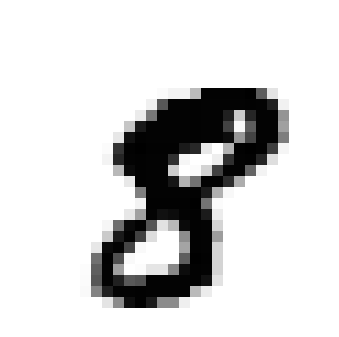

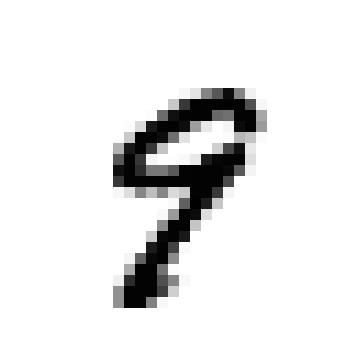

In [4]:
import numpy as np
import seaborn as sns

mnist_X = mnist_train.values[:,1:]        # keeps all columns except the first one (labels)
mnist_y = mnist_train.values[:,0]         # keeps only first column (labels)
mnist_X_final_test = mnist_test.values

for i in range(10,12):
    number_mat = np.reshape(mnist_X[i],(28,28))
    plt.matshow(number_mat)
    plt.grid(False)
    plt.axis('off')

## 2. Split into training and test set

In [5]:
import sys, time
from sklearn.base import clone
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report

# Normalizes data set [from 0 to 1] (for better results with NN)
mnist_X_norm = mnist_X / 255.

# creating the training and test datasets
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(mnist_X_norm, mnist_y,
                                                                            test_size=0.20, random_state=0)

## 3. Choose an estimator

In [ ]:
############ INSTALLATION of SKNN and THEANO on Windows 10 #################
#!pip install scikit-neuralnetwork
#!pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
#!conda install mingw libpython
#!conda install pydot-ng
#and install a c++ compiler: TDM GCC x64 on their website (tdm64-gcc-5.1.0-2.exe)
#Note: make sure there is only one gcc compiler in the environment PATH
############################################################################

In [6]:
#from sknn.platform import gpu32
from sknn.mlp import Classifier, Layer 
from sklearn.metrics import accuracy_score, f1_score

parametersNN = {
                    'layers': [ Layer("Sigmoid", units=25),   # try Rectifier/100
                                Layer("Softmax")],
                    'regularize' : 'L2',
                    #'loss_type' : 'mse',            # not for classification
                    'verbose' : 1,
                    'learning_rate' : 0.01,
                     #learning_rule='nesterov',
                    'weight_decay' : 0.0001,         # weight_decay = regularization
                    'learning_momentum' : 0.99,
                    'n_iter' : 10,
                    'batch_size' : 100                # batch_size=1: each sample is treated on its own
                    #valid_size=0.0,
                    #n_stable=10,
                }


nn = Classifier(**parametersNN)

#### Sanity check: make sure the estimator converges

In [9]:
t0 = time.time()
nn.fit(mnist_X_train, mnist_y_train) 
print "Fit in %0.3fs" % (time.time() - t0)
print
print "Accuracy on test set (before fine-tuning hyperparameters): %7.4f" % accuracy_score(mnist_y_test, nn.predict(mnist_X_test), 
                                                     normalize=True)
print
print "F1 on test set (before fine-tuning hyperparameters): %7.4f" % f1_score( mnist_y_test, nn.predict(mnist_X_test), average='micro' )
print
#print nn.get_parameters()     # shows the weight matrices

Fit in 7.699s

[(8400L, 10L)]
Accuracy on test set (before fine-tuning hyperparameters):  0.8917

[(8400L, 10L)]
F1 on test set (before fine-tuning hyperparameters):  0.8917



## 4. Choose cross-validation iterator

In [10]:
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(mnist_X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)    

## 5. Tune the hyperparameters (RandomizedSearch)
Applying the cross-validation iterator on the training set.  
Note: the scorer must be chosen carefully - here let's use F1 (classification problem).  
For other evaluation metrics (scoring): see http://scikit-learn.org/stable/modules/model_evaluation.html

In [33]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

# specify parameters and distributions to sample from
param_dist = {  "learning_rate"     : np.logspace(-4, -2, 3),  # 3 numbers from 1e-4 to 1e-2
                "weight_decay"      : np.logspace(-4, -2, 3),
                "learning_momentum" : [0.33, 0.66, 0.99],
                "batch_size"        : [50, 100, 200]}

# run randomized search
n_iter_search = 9 # must be less than the number of combination of param_dist
scoring_method = 'f1_micro'
print 'Randomized search for:', param_dist
nn_random_search = RandomizedSearchCV(nn, param_distributions=param_dist, scoring=scoring_method, 
                                          n_iter=n_iter_search, n_jobs=-1, cv=cv, verbose=2)

random_search = nn_random_search.fit(mnist_X_train, mnist_y_train)
print "Best parameters set found for training set:"
print random_search.best_score_, random_search.best_params_
print
print "RandomizedSearchCV scores on training set:"
for params, mean_score, scores in random_search.grid_scores_:
    print "%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params)

Randomized search for: {'learning_rate': array([ 0.0001,  0.001 ,  0.01  ]), 'weight_decay': array([ 0.0001,  0.001 ,  0.01  ]), 'learning_momentum': [0.33, 0.66, 0.99], 'batch_size': [50, 100, 200]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.3min finished


Best parameters set found for training set:
0.86125 {'learning_rate': 0.01, 'weight_decay': 0.001, 'learning_momentum': 0.66, 'batch_size': 50}

RandomizedSearchCV scores on training set:
0.815 (+/-0.019) for {'learning_rate': 0.01, 'weight_decay': 0.0001, 'learning_momentum': 0.99, 'batch_size': 100}
0.137 (+/-0.075) for {'learning_rate': 0.0001, 'weight_decay': 0.001, 'learning_momentum': 0.66, 'batch_size': 50}
0.719 (+/-0.037) for {'learning_rate': 0.01, 'weight_decay': 0.001, 'learning_momentum': 0.99, 'batch_size': 200}
0.613 (+/-0.045) for {'learning_rate': 0.001, 'weight_decay': 0.01, 'learning_momentum': 0.33, 'batch_size': 50}
0.817 (+/-0.015) for {'learning_rate': 0.01, 'weight_decay': 0.0001, 'learning_momentum': 0.66, 'batch_size': 100}
0.115 (+/-0.049) for {'learning_rate': 0.0001, 'weight_decay': 0.0001, 'learning_momentum': 0.99, 'batch_size': 100}
0.861 (+/-0.010) for {'learning_rate': 0.01, 'weight_decay': 0.001, 'learning_momentum': 0.66, 'batch_size': 50}
0.254 (+/-

In [53]:
parametersNN_opt = {
                    'layers': [ Layer("Sigmoid", units=25),   
                                Layer("Softmax")],
                    'regularize' : 'L2',
                    'verbose' : 1,
                    'learning_rate' : random_search.best_params_['learning_rate'],
                    'weight_decay' : random_search.best_params_['weight_decay'],
                    'learning_momentum' : random_search.best_params_['learning_momentum'],
                    'n_iter' : 10,
                    'batch_size' : random_search.best_params_['batch_size'],    
                    #'valid_size' : 0.20,   
                    #'n_stable' : 10
                }

print parametersNN_opt

{'layers': [<sknn.nn.Layer `Sigmoid`: units=25, frozen=False>, <sknn.nn.Layer `Softmax`: frozen=False>], 'regularize': 'L2', 'learning_momentum': 0.66, 'verbose': 1, 'n_iter': 10, 'valid_size': 0.2, 'learning_rate': 0.01, 'weight_decay': 0.001, 'n_stable': 10, 'batch_size': 50}


## 6. Debug algorithm with learning curve

X_train is randomly split into a training and a test set 5 times (n_iter=5). Each point on the training-score curve is the average of 5 scores where the model was trained and evaluated on the first i training examples. Each point on the cross-validation score curve is the average of 5 scores where the model was trained on the first i training examples and evaluated on all examples of the test set.

In [15]:
from sklearn.learning_curve import learning_curve
from sklearn import cross_validation

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score: " + str(scoring))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    plt.gca().invert_yaxis()
    
    return plt

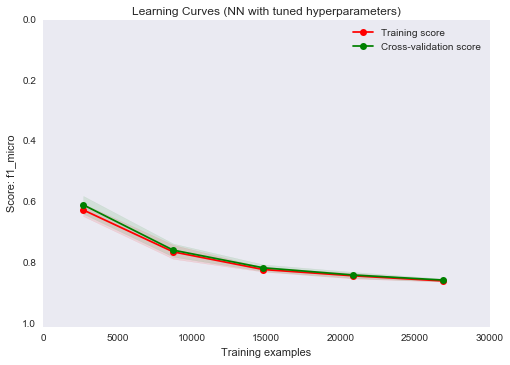

In [16]:
title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = Classifier(**parametersNN_opt)           # classifier with the tuned hyperparameters 
plot_learning_curve(estimator, title, mnist_X_train, mnist_y_train, 
                    ylim=(0.0, 1.01), cv=cv, n_jobs=-1, scoring=scoring_method)
plt.show()

#### Using the learning curves to improve the learning algorithm (Bias/Variance trade-off)


##### High Bias

If the learning algorithm suffers from high bias, the following actions might help:

- Add more features. In the example of predicting home prices, it may be helpful to make use of information such as the neighborhood the house is in, the year the house was built, the size of the lot, etc. Adding these features to the training and test sets can improve a high-bias estimator
- Use a more sophisticated model. Adding complexity to the model can help improve on bias. For a polynomial fit, this can be accomplished by increasing the degree d. Each learning technique has its own methods of adding complexity.
- Use fewer samples. Though this will not improve the classification, a high-bias algorithm can attain nearly the same error with a smaller training sample. For algorithms which are computationally expensive, reducing the training sample size can lead to very large improvements in speed.
- Decrease regularization. Regularization is a technique used to impose simplicity in some machine learning models, by adding a penalty term that depends on the characteristics of the parameters. If a model has high bias, decreasing the effect of regularization can lead to better results.

##### High Variance

If the learning algorithm suffers from high variance, the following actions might help:

- Use fewer features. Using a feature selection technique may be useful, and decrease the over-fitting of the estimator.
- Use more training samples. Adding training samples can reduce the effect of over-fitting, and lead to improvements in a high variance estimator.
- Increase Regularization. Regularization is designed to prevent over-fitting. In a high-variance model, increasing regularization can lead to better results.

Source: http://www.astroml.org/sklearn_tutorial/practical.html

## 7. Prediction on the test set and Final evaluation


Fit in 20.051s
[(8400L, 10L)]
             precision    recall  f1-score   support

          0       0.93      0.96      0.94       813
          1       0.95      0.97      0.96       961
          2       0.93      0.89      0.91       860
          3       0.91      0.88      0.90       863
          4       0.91      0.93      0.92       827
          5       0.89      0.87      0.88       756
          6       0.92      0.95      0.94       841
          7       0.92      0.92      0.92       899
          8       0.88      0.86      0.87       768
          9       0.89      0.86      0.88       812

avg / total       0.91      0.91      0.91      8400



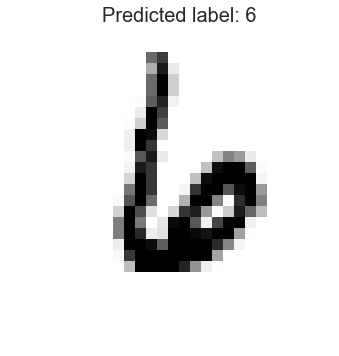

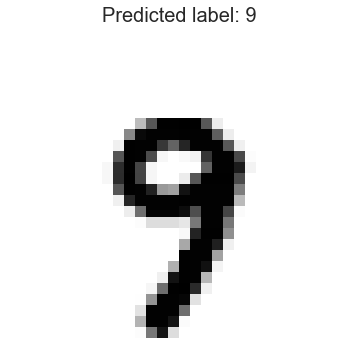

In [22]:
t0 = time.time()
estimator.fit(mnist_X_norm, mnist_y) 
print "Fit in %0.3fs" % (time.time() - t0)

mnist_y_pred = estimator.predict(mnist_X_test)

for i in range(1,3):
    number_mat = np.reshape(mnist_X_test[i],(28,28))
    plt.matshow(number_mat)
    plt.title('Predicted label: ' + str( mnist_y_pred[i][0] ), fontsize=20)
    plt.grid(False)
    plt.axis('off')

print classification_report(mnist_y_test, mnist_y_pred)